## Half model
This notebook demonstrates splitting the data in half and using each half to build a model which performs very well on the public LB with minimal feature engineering.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import math
import timeit
import gc
import os
import random

# Visualiazation
from seaborn import countplot
import matplotlib.pyplot as plt
import seaborn

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Imputer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


from imblearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score, mean_squared_error

# Models and multiclasses support
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

# Model tuning
from sklearn.model_selection import GridSearchCV

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# Import and suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Settings
path_data = 'input_files/TEST/'
path_train = path_data + 'train.csv'
path_test = path_data + 'test.csv'

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

# Is it regression/binary classification/multi class classification?
task = 1  # regression
task = 2  # binary classification
task = 3  # multiclass classification

# Number of classes for multiclass
num_class = 4

In [3]:
task = 3  # multi class classification

In [4]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    ''' Roc auc calculation for multiclass task '''

    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


def SecondsToStr(time_taken):
    ''' Function return time in convenient format (hours, minutes, seconds) '''

    hours, rest = divmod(time_taken, 3600)
    minutes, seconds = divmod(rest, 60)

    return str(math.trunc(hours)) + ':' + str(math.trunc(minutes)) + ':' + str(
        round(seconds, 2))


def reduce_mem_usage(df, use_float16=False):
    ''' Memory optimization
    Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
    Modified to support timestamp type, categorical type
    Modified to add option to use float16
    
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage '''

    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(
        100 * (start_mem - end_mem) / start_mem))

    return df

## Reading train and test data
Reading train data

In [5]:
# Upload train and test sets
df_train = pd.read_csv(path_train).reset_index()
df_test = pd.read_csv(path_test).reset_index()

# Set target and id columns
target = '66'
row_id = 'index'

# Check the shape
print('Train:', df_train.shape)
print('Test:', df_test.shape)

Train: (8678, 67)
Test: (3000, 67)


In [6]:
##### TEST #####

# Set for learning
df_train = df_train.iloc[3000:-100,:]

# Set for model/parameter tuning
df_train_out = df_train.iloc[-100:, :]

   
if task == 2:
    df_train.loc[df_train[target] == 2, target] = 0
    df_train.loc[df_train[target] == 3, target] = 1
    df_test.loc[df_test[target] == 2, target] = 0
    df_test.loc[df_test[target] == 3, target] = 1
    
    
if task == 1:
    y_test = df_test[target]
else:
    y_test = df_test.iloc[:, 66:67]

print('Train:', df_train.shape)
print('Test:', df_test.shape)
##### TEST #####

Train: (5578, 67)
Test: (3000, 67)


## Preprocessing

In [7]:
# Concatenate train and test sets before preprocessing
df = pd.concat([df_train, df_test])
print('Train + Test:', df.shape)
df.head(5)

Train + Test: (8578, 67)


,index,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
3000,3000,-70,-21,18,-22,-19.0,37.0,95.0,-30.0,79,...,37,-28,-9,22,17,-6,50,-40,C,0
3001,3001,20,15,-5,-12,21.0,27.0,-2.0,1.0,-18,...,-10,9,2,12,-8,-21,-10,-62,D,2
3002,3002,37,-6,-1,-6,-17.0,-5.0,44.0,-5.0,5,...,2,2,0,3,9,-5,62,26,C,0
3003,3003,49,-4,-4,-6,10.0,-6.0,-41.0,11.0,-16,...,6,-4,0,5,19,16,38,1,C,0
3004,3004,36,4,4,14,-4.0,-14.0,47.0,2.0,17,...,7,-2,1,5,-3,2,-50,-29,C,0


In [8]:
column_lst = [x for x in list(df.columns) if x not in [row_id, target, '65']]

In [9]:
def average_imputation(X, column_name):
    imputation = X.groupby(['timestamp'])[column_name].mean()
    
    X.loc[X[column_name].isnull(), column_name] = X[X[column_name].isnull()][[column_name]].apply(lambda x: imputation[X['timestamp'][x.index]].values)
    del imputation
    return df

# MISSING
# Fill in missing values
# df = df.groupby('cat_column').apply(lambda group: group.interpolate(limit_direction='both'))

# df['Color'].fillna('missing', inplace=True)
df[column_lst] = df[column_lst].fillna(df[column_lst].mean())

# filling missing with average inputatioin
# df = average_imputation(df, ['num_column3'])

# CATEGORICAL
# Encoding categorical variables
#le = LabelEncoder()
#df['Color'] = le.fit_transform(df['Color'])

# NEW FEATURES (TIMESTAMP)
# convert timestamp to datetime and sorting
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d.%m.%Y %H:%M:%S")
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d.%m.%Y")
# df.sort_values('Timestamp', inplace = True)
# df.reset_index(drop=True)
# gc.collect()

# New features from timestamp
# df['hour'] = df['Timestamp'].dt.hour
# df['weekday'] = df['Timestamp'].dt.weekday 
# df['month'] = df['Timestamp'].dt.month

# SCALING
df[column_lst] = Normalizer().fit_transform(df[column_lst])
#df['Price1'] = np.log1p(df['Price1'])
#df['Price2'] = np.log1p(df['Price2'])
#df['Year'] = df['Year']-1900

# OUTLIERS
# df[column_lst] = RobustScaler().fit_transform(df[column_lst])


In [10]:
# Split train and test sets after preprocessing
df_train = df[:df_train.shape[0]]
df_test = df[df_train.shape[0]:]

# Check the shape
print('Train:', df_train.shape)
print('Test:', df_test.shape)

Train: (5578, 67)
Test: (3000, 67)


In [11]:
del df
gc.collect()

21

In [12]:
df_train.head(2)

,index,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
3000,3000,-0.211918,-0.063575,0.054493,-0.066603,-0.057521,0.112014,0.287603,-0.090822,0.239165,...,0.112014,-0.084767,-0.027247,0.066603,0.051466,-0.018164,0.151370,-0.121096,C,0
3001,3001,0.124744,0.093558,-0.031186,-0.074847,0.130982,0.168405,-0.012474,0.006237,-0.112270,...,-0.062372,0.056135,0.012474,0.074847,-0.049898,-0.130982,-0.062372,-0.386708,D,2


In [13]:
df_test.head(2)

,index,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0,-0.280274,0.000000,-0.029816,-0.161008,-0.065596,-0.113302,-0.011927,-0.196788,0.220641,...,0.000000,0.011927,-0.023853,-0.01789,0.023853,-0.137155,-0.405502,0.089449,A,0
1,1,0.006617,0.006617,-0.013233,-0.019850,-0.006617,-0.019850,0.258052,0.066167,0.000000,...,-0.046317,-0.013233,0.006617,0.03970,-0.013233,0.026467,0.145568,0.013233,C,0


## Preparing data
Simple preparation

In [14]:
def prepare_data(X, test=False):
    '''
    Preparing final dataset with all features.
    '''

    # Drop redundant columns
    drop_features = ['65']
    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X[row_id]
        X.drop(row_id, axis=1, inplace=True)
        X.drop(target, axis=1, inplace=True)
        return X, row_ids
    else:
        # y = np.log1p(X[target])
        # y = X[target]

        if task == 1:  # regression
            y = np.log1p(X[target])
        else:  # classification
            y = X.iloc[:, 65:66]
        X.drop(row_id, axis=1, inplace=True)
        X.drop(target, axis=1, inplace=True)
        return X, y

In [15]:
df_train = reduce_mem_usage(df_train)
X_train, y_train = prepare_data(df_train)

del df_train
gc.collect()

X_train.head(2)

Memory usage of dataframe is 2.89 MB
Memory usage after optimization is: 1.43 MB
Decreased by 50.7%


,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
3000,-0.211918,-0.063575,0.054493,-0.066603,-0.057521,0.112014,0.287603,-0.090822,0.239165,-0.084767,...,0.311822,0.142288,0.112014,-0.084767,-0.027247,0.066603,0.051466,-0.018164,0.151370,-0.121096
3001,0.124744,0.093558,-0.031186,-0.074847,0.130982,0.168405,-0.012474,0.006237,-0.112270,0.018712,...,0.006237,-0.024949,-0.062372,0.056135,0.012474,0.074847,-0.049898,-0.130982,-0.062372,-0.386708


In [16]:
df_test = reduce_mem_usage(df_test)
X_test, row_ids = prepare_data(df_test, test=True)

del df_test
gc.collect()

X_test.head(2)

Memory usage of dataframe is 1.56 MB
Memory usage after optimization is: 0.77 MB
Decreased by 50.7%


,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
0,-0.280274,0.000000,-0.029816,-0.161008,-0.065596,-0.113302,-0.011927,-0.196788,0.220641,0.000000,...,0.119265,-0.137155,0.000000,0.011927,-0.023853,-0.01789,0.023853,-0.137155,-0.405502,0.089449
1,0.006617,0.006617,-0.013233,-0.019850,-0.006617,-0.019850,0.258052,0.066167,0.000000,-0.006617,...,0.357303,0.112484,-0.046317,-0.013233,0.006617,0.03970,-0.013233,0.026467,0.145568,0.013233


## Model: Two-fold LightGBM Model split half-and-half
The data is split into two based on time. Each half is used as the training data for a model.

In [17]:
# from sklearn.model_selection import train_test_split
# Split train data into two parts
# X_half_1, X_half_2 = train_test_split(X_train, test_size=0.5, random_state=myfavouritenumber)
# y_half_1, y_half_2 = train_test_split(y_train, test_size=0.5, random_state=myfavouritenumber)

In [18]:
# Split train set per two halfs
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]


#categorical_features = ['weekday', 'month', 'Color']
categorical_features = []

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)
watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

if task == 1:
# regression task
    params = {
        'objective': 'regression',
        'boosting': 'gbdt',
        'num_leaves': 2**6,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'reg_lambda': 2,
        'metric': 'rmse'
    }

if task == 2:
# binary classication task
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_leaves': 2**6,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'reg_lambda': 2,
        'metric': 'auc'
    }
    
if task == 3:
# multi class task
    params = {
        'objective': 'multiclass',
        'boosting_type': 'gbdt',
        'num_leaves': 2**6,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'reg_lambda': 2,
        'num_class': num_class,
        'metric': 'multi_error'
    }
    
print(params['objective'])

multiclass


In [19]:
start = timeit.default_timer()
print('Building model with first half and validating on second half:')
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=500, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)
print('________Time: ', SecondsToStr(timeit.default_timer() - start))

start = timeit.default_timer()
print('Building model with second half and validating on first half:')
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=500, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)
print('________Time: ', SecondsToStr(timeit.default_timer() - start))

Building model with first half and validating on second half:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[200]	training's multi_error: 0	valid_1's multi_error: 0.055934
Early stopping, best iteration is:
[90]	training's multi_error: 0	valid_1's multi_error: 0.0681248
________Time:  0:1:50.6
Building model with second half and validating on first half:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[200]	training's multi_error: 0	valid_1's multi_error: 0.0598781
Early stopping, best iteration is:
[138]	training's multi_error: 0	valid_1's multi_error: 0.0638222
________Time:  0:1:46.39


In [20]:
# Averaging predictions from the two half train data models.
if task == 1: # regression or binary
    y_pred_lgb = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2
    y_pred_lgb += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
else:  # classification
    y_pred_lgb = model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration) / 2
    y_pred_lgb += model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration) / 2

In [21]:
if task == 3: # multi class task
    # Output position with highest probability
    y_pred_lgb = (pd.DataFrame(y_pred_lgb).idxmax(axis=1))

In [22]:
if task == 1: # regression
    print('mse:', mean_squared_error(y_test, y_pred_lgb))
if task == 2: # binary classification
    print('roc_auc:', roc_auc_score(y_test, y_pred_lgb))
if task == 3: # multi class task
    print('roc_auc:', multiclass_roc_auc_score(y_test, y_pred_lgb))

roc_auc: 0.964463663556896


## Model: XGBoost

In [23]:
start = timeit.default_timer()
# отмасштабируем признаки
scaler = Normalizer()
# исбавимся от выбросов после масщтабирования, если они будет в тестовой выборке
outlier = RobustScaler()
# для уменьшения несбаллансированности классов воспользуемся техникой Oversampling
# smote = SMOTE(random_state=myfavouritenumber)
# пустые значения заменим на среднее ззначение признака
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


if task == 1:  # regression
    model = XGBClassifier(random_state=myfavouritenumber)
    
if task == 2:  # binary classification
    model = XGBClassifier(random_state=myfavouritenumber)

if task == 3:  # multi class task
    model = MultiOutputClassifier(XGBClassifier(random_state=myfavouritenumber), n_jobs=-1)
    
# Create pipeline
pipeline = Pipeline([('imputer', imputer),
                     ('scaler', scaler),
                     ('outlier', outlier),
                     #('smote', smote),
                     ('XGBoost', model)])

# Fit model and predict
xgb = pipeline.fit(X_train, y_train)

if task == 1: # regression
    y_pred_xgb = np.expm1(xgb.predict(X_test))
else:  # classification
    y_pred_xgb = xgb.predict(X_test)
print('________Time: ', SecondsToStr(timeit.default_timer() - start))

________Time:  0:0:9.93


In [24]:
if task == 1: # regression
    print('mse:', mean_squared_error(y_test, y_pred_xgb))
if task == 2: # binary classification
    print('roc_auc:', roc_auc_score(y_test, y_pred_xgb))
if task == 3: # multi class task
    print('roc_auc:', multiclass_roc_auc_score(y_test, y_pred_xgb))

roc_auc: 0.961564966068195


## Submission
Preparing final file for submission.

In [25]:
y_pred = y_pred_lgb
submission = pd.DataFrame({row_id: row_ids, target: y_pred})
# submission = pd.DataFrame({row_id: row_ids, target: np.clip(pred, 0, a_max=None)})
# submission.to_csv('test_submission.csv', index=False, float_format='%.4f')

## Prediction review

In [26]:
if task == 1 or task == 2: # regression
    print('y_test:    ',  1.*(np.array(y_test[:20])))
    print('y_pred_lgb:',np.round(y_pred_lgb)[:20])
    print('y_pred_xgb:', 1.*np.round(np.array(y_pred_xgb))[:20])
else:
    print('y_test:',  np.array(y_test[target][:20]))
    print('y_pred_lgb:', np.array(y_pred_lgb)[:20])
    print('y_pred_xgb:', np.array(y_pred_xgb)[:20])
    

y_test: [0 0 1 0 0 0 0 3 2 0 3 0 3 2 1 1 2 2 0 0]
y_pred_lgb: [0 0 1 0 0 0 0 3 2 0 3 0 3 2 1 1 2 2 0 2]
y_pred_xgb: [[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [3]
 [2]
 [0]
 [3]
 [0]
 [3]
 [1]
 [1]
 [1]
 [2]
 [2]
 [0]
 [2]]


In [27]:
#y_pred.describe()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


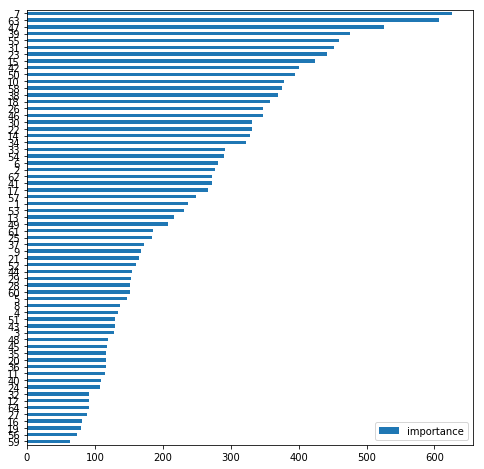

In [28]:
import matplotlib.pyplot as plt
def plot_feature_importance(model_, model_columns_):
    importance_df = pd.DataFrame(model_.feature_importance(),
                                 index=model_columns_,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()
    
plot_feature_importance(model_half_1 , list(X_test.columns))

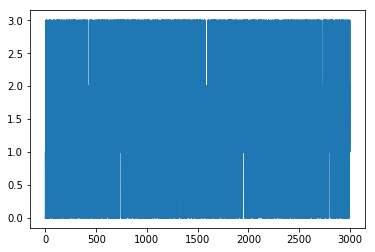

In [29]:
import matplotlib as mpl
submission[target].plot()
plt.show()

In [30]:
stop

NameError: name 'stop' is not defined

In [ ]:
del X_train, y_train, X_test, y_test, X_half_1, X_half_2, y_half_1, y_half_2, d_half_1, d_half_2, watchlist_1, watchlist_2, model_half_1, model_half_2
gc.collect()